<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/main/0_baseline_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This file does NOT contain high quality code! This file is dedicated to the skill of writing pipelines quickly

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [2]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()


In [61]:
def report_results(model, X, Y):
    print(mean_squared_error(model.predict(X), Y, squared=False))

# Download the data

In [88]:
df_train = pd.read_csv(manager.train_path, index_col='id')
df_submission = pd.read_csv(manager.test_path, index_col='id')

df_train.size, df_submission.size

assert set(df_train.columns) - set(df_submission.columns) == {'price'}

- For now, we will look only at the train dataset

# Quick look at the data

In [ ]:
df_submission.head(3)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
id,,,,,,,,,,,,,,,,
22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8
22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4
22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2


In [ ]:
df_train.head(3)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1


In [ ]:
df_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')

In [ ]:
df_train.dtypes

squareMeters           int64
numberOfRooms          int64
hasYard                int64
hasPool                int64
floors                 int64
cityCode               int64
cityPartRange          int64
numPrevOwners          int64
made                   int64
isNewBuilt             int64
hasStormProtector      int64
basement               int64
attic                  int64
garage                 int64
hasStorageRoom         int64
hasGuestRoom           int64
price                float64
dtype: object

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22730 entries, 0 to 22729
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       22730 non-null  int64  
 1   numberOfRooms      22730 non-null  int64  
 2   hasYard            22730 non-null  int64  
 3   hasPool            22730 non-null  int64  
 4   floors             22730 non-null  int64  
 5   cityCode           22730 non-null  int64  
 6   cityPartRange      22730 non-null  int64  
 7   numPrevOwners      22730 non-null  int64  
 8   made               22730 non-null  int64  
 9   isNewBuilt         22730 non-null  int64  
 10  hasStormProtector  22730 non-null  int64  
 11  basement           22730 non-null  int64  
 12  attic              22730 non-null  int64  
 13  garage             22730 non-null  int64  
 14  hasStorageRoom     22730 non-null  int64  
 15  hasGuestRoom       22730 non-null  int64  
 16  price              227

In [ ]:
df_train.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,2.273000e+04,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,2.273000e+04
mean,4.658622e+04,48.241091,0.475891,0.452750,47.305983,50013.795996,5.585042,5.620766,2008.005059,0.467972,0.460009,5283.646634,5067.981698,530.469644,0.461681,5.153058,4.634457e+06
std,4.952124e+04,28.226428,0.499429,0.497773,47.777207,30006.637729,2.739533,2.713026,118.826777,0.498984,0.498409,3047.084412,3097.347939,274.840604,0.498540,3.055246,2.925163e+06
min,8.900000e+01,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04
25%,2.039275e+04,25.000000,0.000000,0.000000,25.000000,22936.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2977.250000,2599.000000,297.000000,0.000000,3.000000,2.041739e+06
50%,4.448400e+04,47.000000,0.000000,0.000000,45.000000,50414.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,4977.000000,515.000000,0.000000,5.000000,4.450823e+06
75%,7.154700e+04,75.000000,1.000000,1.000000,69.000000,76291.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7746.000000,7652.000000,767.000000,1.000000,8.000000,7.159920e+06
max,6.071330e+06,100.000000,1.000000,1.000000,6000.000000,491100.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000428e+07


## NAN

In [ ]:
from sklearn_utils import nan_report

_ = nan_report(df_train, 0.0)

0 / 17 cols (0.0 %) have nan % > 0.0

Series([], dtype: float64)


- All training data is numeric
- No NAN values

# Outlier cleaning

6071330 before
98788 after


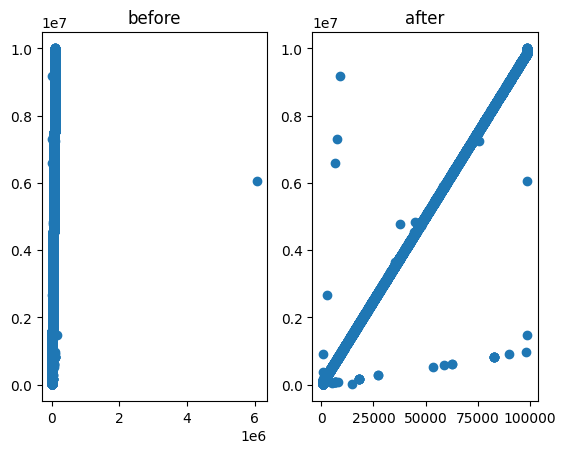

In [89]:
from sklearn_utils import dict_subset

LOW_PERCENTILE = 0.01
HIGH_PERCENTILE = 0.99

features = ['squareMeters']
for feature in features:
    for df in [df_train]:
        _, ax_1 = plt.subplots(1, 2)
        print(df[feature].max(), 'before')
        if 'price' in df.columns:
            ax_1[0].scatter(df[feature], df['price'])
        ax_1[0].set_title('before')

        df[feature] = df[feature].clip(
            lower=df[feature].quantile(0.01),
            upper=df[feature].quantile(0.99)
        )
        if 'price' in df.columns:
            ax_1[1].scatter(df[feature], df['price'])
        ax_1[1].set_title('after')

        print(df[feature].max(), 'after')

# Anomaly cleaning

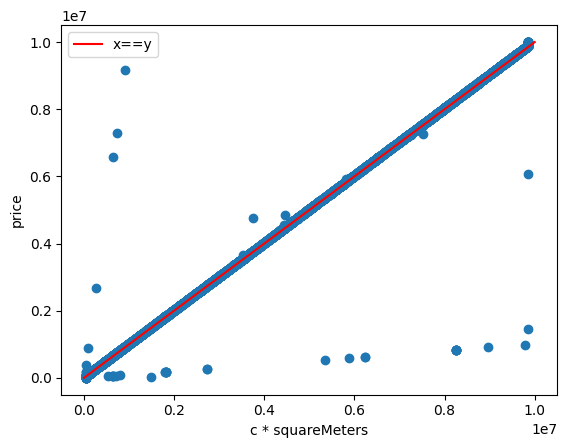

In [90]:
COEF = 99.7

_, ax = plt.subplots()
p = [COEF * s for s in df_train['squareMeters']]
ax.scatter(x=p, y=df_train['price'])
ax.set_xlabel('c * squareMeters')
ax.set_ylabel('price')

ax.plot(np.linspace(0, 10000000, 50), np.linspace(0, 10000000, 50), color='red', label='x==y')
ax.legend()

In [91]:
df_train['anomaly_distance'] = df_train['price'] - df_train['squareMeters'] * COEF

subset shape: (22702, 18) original shape: (22730, 18)


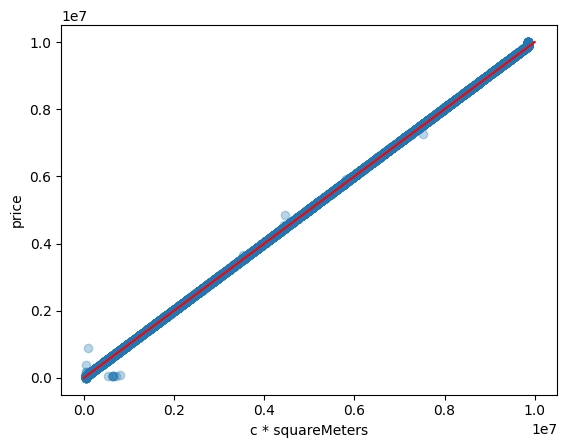

In [92]:
ANOMALY_THRESHOLD = 1000000

df_subset = df_train.loc[abs(df_train['anomaly_distance']) <= ANOMALY_THRESHOLD, :]
print('subset shape:', df_subset.shape, 'original shape:', df_train.shape)

_, ax = plt.subplots()
p = [COEF * s for s in df_subset['squareMeters']]
ax.scatter(x=p, y=df_subset['price'], alpha=0.3)
ax.set_ylabel('price')
ax.set_xlabel('c * squareMeters')
plt.plot(np.linspace(0, 10000000, 50), np.linspace(0, 10000000, 50), color='red')

In [93]:
# clean the noise
df_train['anomaly_distance'] = df_train['price'] - df_train['squareMeters'] * COEF
print(f'Shape before: {df_train.shape}')
df_train = df_train.loc[abs(df_train['anomaly_distance']) <= ANOMALY_THRESHOLD, :]
print(f'Shape after: {df_train.shape}')


Shape before: (22730, 18)
Shape after: (22702, 18)


In [94]:
df_train.drop('anomaly_distance', axis='columns', inplace=True)

<ipython-input-94-fea9bdcbfdec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('anomaly_distance', axis='columns', inplace=True)


# Split the data

In [95]:
from sklearn.model_selection import train_test_split

TRAINVAL_SIZE = 0.8
TRAIN_SIZE = 0.8
RANDOM_STATE = 42

df_trainval, df_test = train_test_split(
    df_train,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE
)

df_train, df_val = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE
)

df_train.size, df_val.size, df_test.size, df_submission.size

(246976, 61761, 77197, 242464)

In [96]:
EXPLORATION_SIZE = 0.01

df_exploration, _ = train_test_split(
    df_train,
    train_size=EXPLORATION_SIZE,
    random_state=RANDOM_STATE
)

df_exploration.size

2465

In [97]:
def X_Y(df, return_y):
    if return_y:
        X=df.loc[:, [c for c in df.columns if c != 'price']]
        y=df[['price']].values.ravel()
    else:
        X = df.loc[:, :]
        y = None
    return X, y

X_train, Y_train = X_Y(df_train, True)
X_val, Y_val = X_Y(df_val, True)
X_test, Y_test = X_Y(df_test, True)
X_exploration, Y_exploration = X_Y(df_exploration, True)

X_submission, _ = X_Y(df_submission, False)

In [98]:
Xs = {
    'train': X_train,
    'val': X_val,
    'test': X_test,
    'exploration': X_exploration,
    'submission': X_submission
}

Ys = {
   'train': Y_train,
   'val': Y_val,
   'test': Y_test,
   'exploration': Y_exploration
}

In [99]:
X_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom'],
      dtype='object')

In [100]:
Xs['train'].columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom'],
      dtype='object')

### Verify that the data is from the same distribution

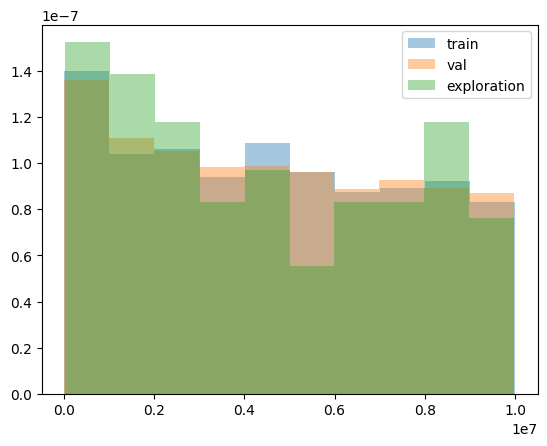

In [101]:
_, ax = plt.subplots()

ax.hist(Y_train, density=True, alpha=0.4, label='train')
ax.hist(Y_val, density=True, alpha=0.4, label='val')
ax.hist(Y_exploration, density=True, alpha=0.4, label='exploration')

ax.legend()

# Dumb baseline for reference (no preprocessing / feature engineering)

In [ ]:
df_train.shape, df_val.shape, df_test.shape, df_submission.shape

((9309, 17), (2328, 17), (2910, 17), (15154, 16))

In [ ]:
X_train.shape

(9309, 16)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_dummy = RandomForestRegressor(n_estimators=2)
rf_dummy.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=2)

In [ ]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(rf_dummy.predict(X_train), Y_train, squared=False))
print(mean_squared_error(rf_dummy.predict(X_val), Y_val, squared=False))

159872.5679132488
252853.36098784165


# Data exploration

<Axes: >

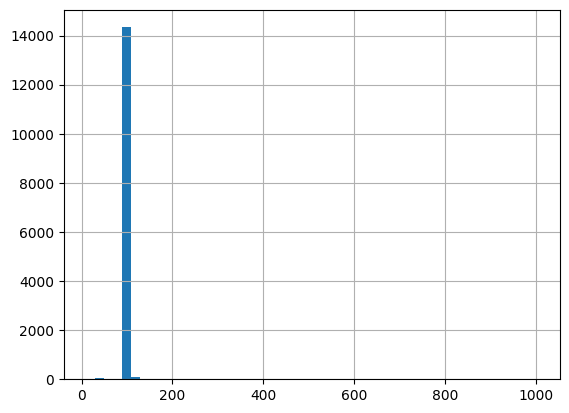

In [117]:
df_train['leak'] = df_train['price'] / df_train['squareMeters']
df_train['leak'].hist(bins=50)

In [119]:
df_train['leak'].mean()

100.19794816038939

In [ ]:
df_train.numberOfRooms.describe()

count    9309.000000
mean       48.362123
std        28.299867
min         1.000000
25%        25.000000
50%        47.000000
75%        75.000000
max       100.000000
Name: numberOfRooms, dtype: float64

<ipython-input-48-0cee6c3cd648>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = df_exploration.hist(ax=ax)


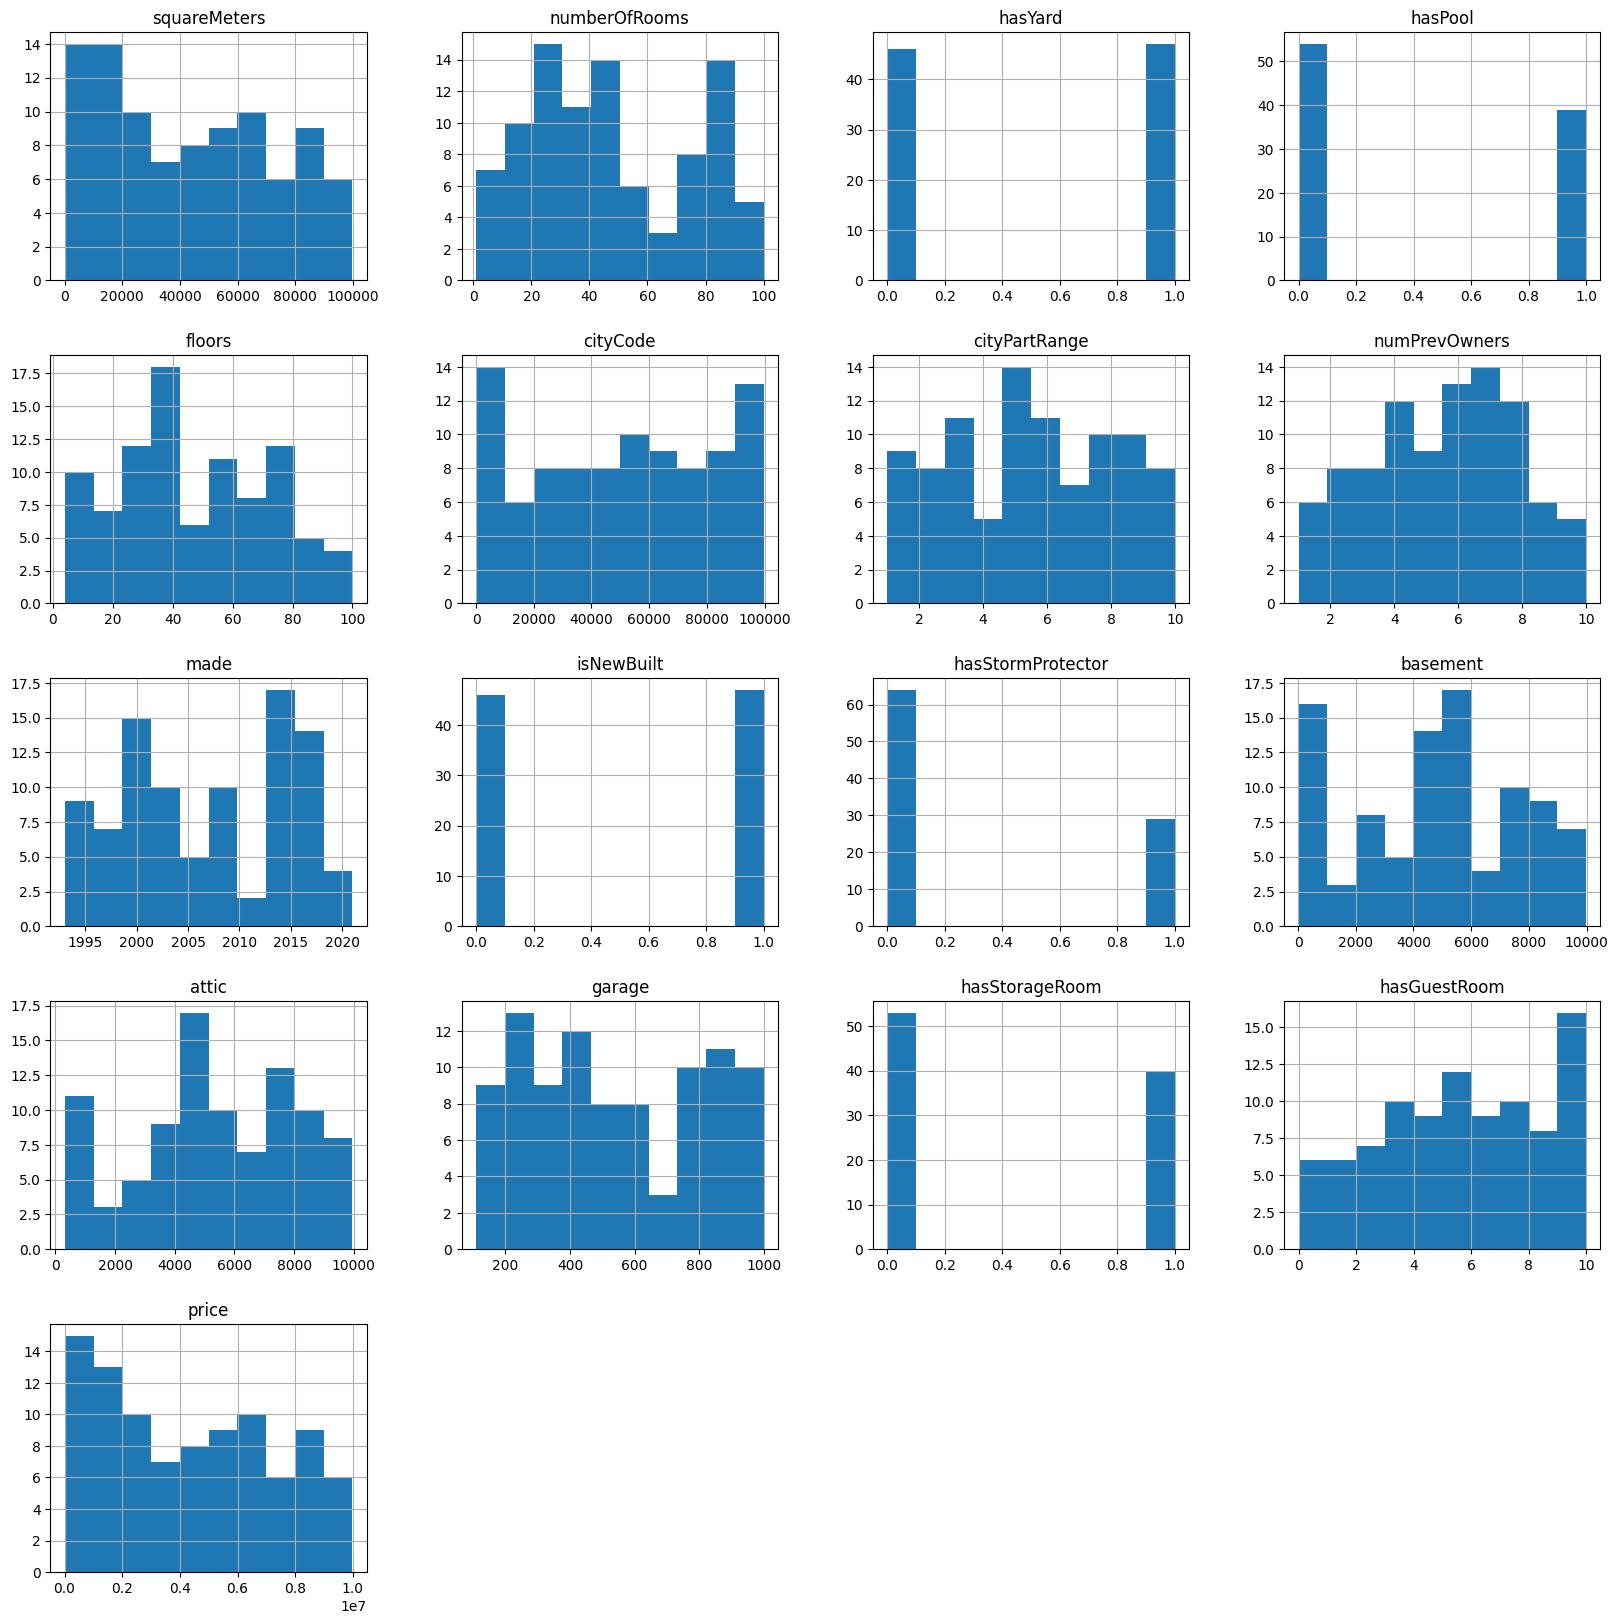

In [ ]:
_, ax = plt.subplots(figsize=(20, 20))
_ = df_exploration.hist(ax=ax)

<Axes: >

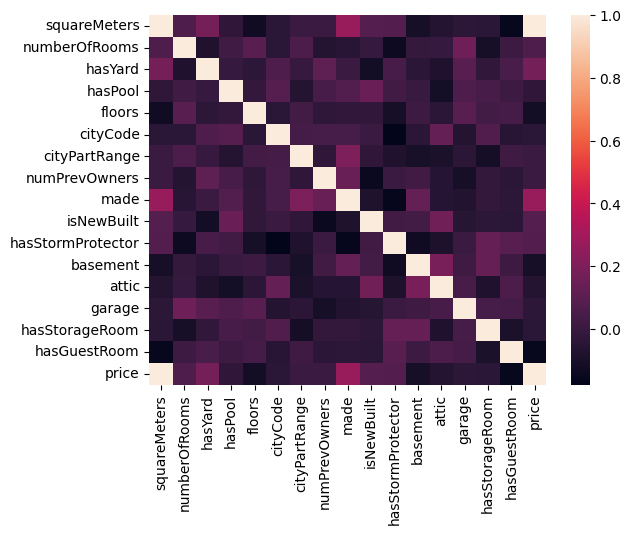

In [55]:
import seaborn as sns

sns.heatmap(
    df_exploration.corr()
)

<Axes: xlabel='squareMeters', ylabel='price'>

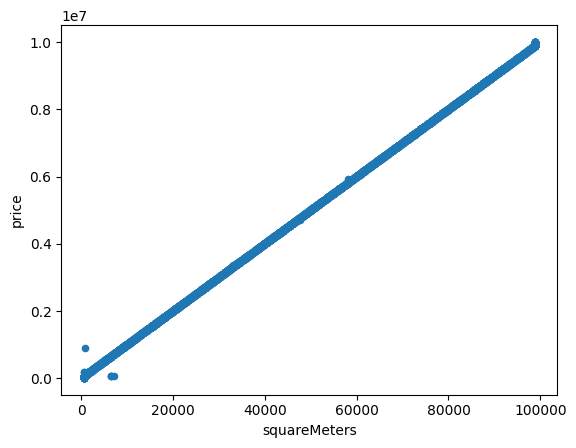

In [58]:
df_train[['price', 'squareMeters']] \
    .plot('squareMeters', 'price', 'scatter')

In [ ]:
df_train['squareMeters'].quantile(0.05), df_train['squareMeters'].quantile(0.99)

(3822.6000000000004, 98689.0)

In [ ]:
df_train['squareMeters'].max()

6071330

<Axes: >

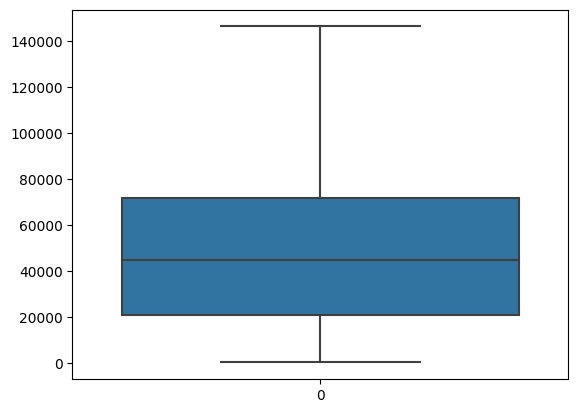

In [ ]:
sns.boxplot(
    df_train.loc[df_train['squareMeters'] < 6071329]['squareMeters'].values
)

In [ ]:
df_train['squareMeters'].describe()

count    1.454700e+04
mean     4.688674e+04
std      5.785984e+04
min      8.900000e+01
25%      2.079500e+04
50%      4.468300e+04
75%      7.167600e+04
max      6.071330e+06
Name: squareMeters, dtype: float64

# Try only linear regression


In [120]:
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
estimator.fit(Xs['train'][['squareMeters']], Ys['train'])

LinearRegression()

14246.929535306119


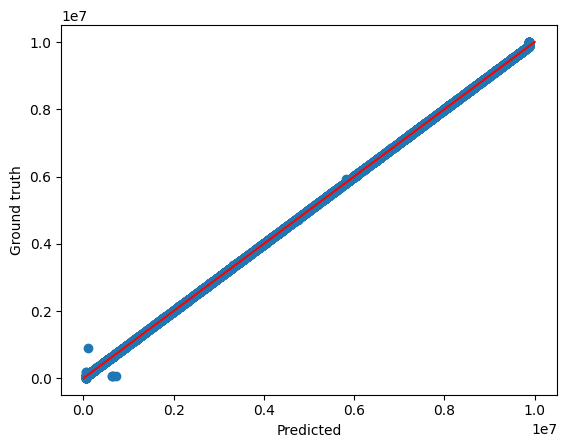

In [121]:
from sklearn.metrics import mean_squared_error

def visualize_predictions(model, X, Y):
    fig, ax = plt.subplots()
    predictions=model.predict(X)
    ax.scatter(x=predictions, y=Y)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Ground truth')
    # ax.set_title()
    max_val = max(np.max(predictions), np.max(Y))
    min_val = min(np.min(predictions), np.min(Y))

    ax.plot(np.linspace(min_val, max_val, 50), np.linspace(min_val, max_val, 50), color='red')


visualize_predictions(estimator, Xs['train'][['squareMeters']], Ys['train'])
report_results(estimator, Xs['train'][['squareMeters']], Ys['train'])

In [123]:
estimator.coef_, estimator.intercept_

(array([100.05049353]), 4129.002539018169)

In [104]:
Xs['train'].shape, Xs['submission'].shape

((14528, 16), (15154, 16))

In [105]:
predictions = estimator.predict(Xs['submission'])

In [106]:
Xs['submission'].head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
id,,,,,,,,,,,,,,,,
22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8
22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4
22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2
22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5
22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9


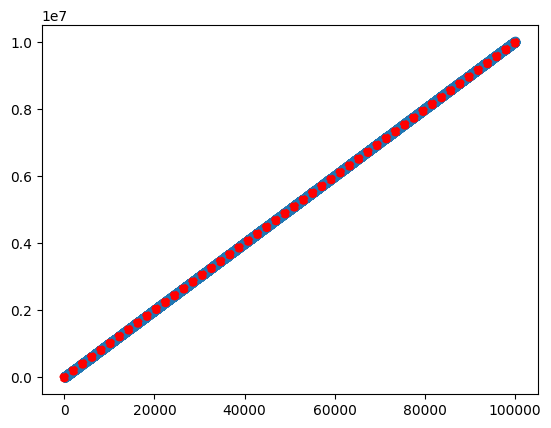

In [107]:
_, ax = plt.subplots()
markevery=1
ax.scatter(y=predictions[::markevery], x=Xs['submission']['squareMeters'][::markevery])
to=Xs['submission']['squareMeters'].max()
ax.scatter(x=np.linspace(0, to, 50), y=COEF*np.linspace(0, to, 50), color='red', linestyle='--')

In [108]:
Xs['submission'].shape

(15154, 16)

In [125]:
Xs['submission']['price'] = Xs['submission']['squareMeters'] * estimator.coef_ + estimator.intercept_
Xs['submission'].head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8,4.764531e+06
22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4,6.215564e+06
22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2,9.058599e+06
22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5,1.640355e+06
22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9,6.758538e+06


In [126]:
Xs['submission'][['price']].head()

,price
id,
22730,4.764531e+06
22731,6.215564e+06
22732,9.058599e+06
22733,1.640355e+06
22734,6.758538e+06


In [113]:
manager.data_trial_path

'/content/gdrive/MyDrive/ML/Competitions/10.ParisHousePrices/Data/preproc_trial_1'

In [127]:
manager.save_to_csv(Xs['submission'][['price']], path_=manager.data_trial_path, file_name_='submission_1.csv')

In [130]:
Xs['submission'].head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8,4.764531e+06
22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4,6.215564e+06
22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2,9.058599e+06
22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5,1.640355e+06
22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9,6.758538e+06


In [ ]:
from sklearn.linear_model import RANSACRegressor

ransac = LinearRegression()
ransac.fit(Xs['train'], Ys['train'])

LinearRegression()

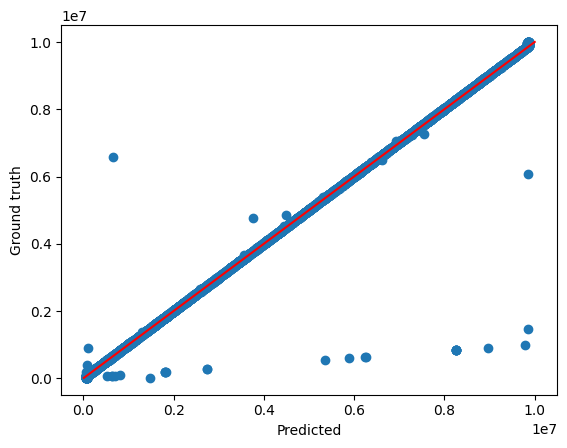

In [ ]:
visualize_predictions(ransac, Xs['train'], Ys['train'])

In [ ]:
Xs['train'].columns.tolist().index('squareMeters')

0

In [ ]:
estimator.coef_, estimator.intercept_

(array([ 9.97661479e+01,  1.23687277e+02,  1.38535769e+03,  6.56874527e+03,
         2.19296733e+01, -1.36933693e-01,  6.74600677e+02, -5.71681857e+02,
         2.06155783e+00,  4.03884948e+02, -1.68703364e+03,  2.12305413e-01,
        -7.17832304e-01, -1.25214171e+01,  8.19525865e+03,  5.81285640e+01]),
 7559.676083618775)

In [ ]:
from sklearn.svm import SVR


svr = SVR()
svr.fit(Xs['train'], Ys['train'])
report_results(svr, Xs['train'], Ys['train'])

2924086.954318275


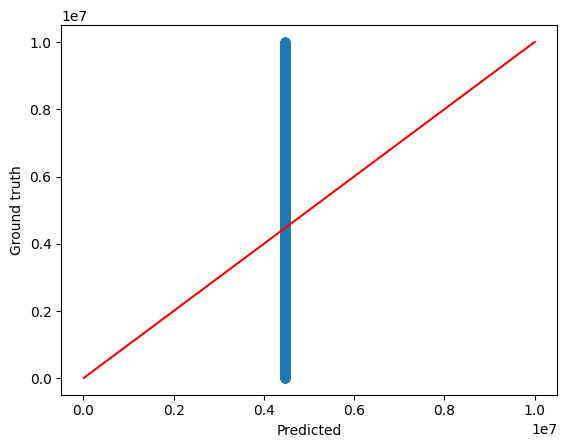

In [ ]:
visualize_predictions(svr, Xs['train'], Ys['train'])

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=15)
knn.fit(Xs['train'], Ys['train'])
report_results(knn, Xs['train'], Ys['train'])

223109.08698060387


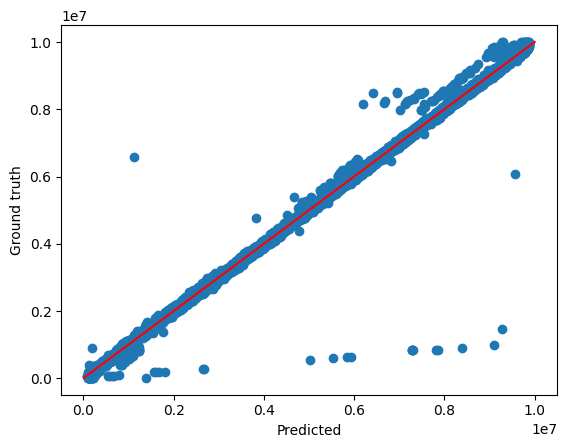

In [ ]:
visualize_predictions(knn, Xs['train'], Ys['train'])

# Feature engineering

## Square per room (average room size)

In [ ]:
def add_number_of_rooms(df):
    print(df['numberOfRooms'].min())
    df['MetersPerRoom'] = df['squareMeters'] / df['numberOfRooms']
    return df


for x in Xs.values():
    assert not 'MetersPerRoom' in x.columns, print(x.columns)
    x = add_number_of_rooms(x)
    assert 'MetersPerRoom' in x.columns

1
1
1
4
1


In [ ]:
for x in Xs.values():
    print(x.shape)

(14547, 17)
(3637, 17)
(4546, 17)
(145, 17)
(15154, 17)


## Feature cross

In [ ]:
def add_category(df):
    df['ApartmentCharacteristic'] = df.apply(
        lambda item: f'{int(item["hasYard"])}x{int(item["hasPool"])}x{int(item["isNewBuilt"])}x{int(item["hasStormProtector"])}x{int(item["hasStorageRoom"])}',
        axis='columns'
    )
    return df

for key, val in Xs.items():
    print('Shape before', val.shape)
    Xs[key] = add_category(val)
    print('Shape after', val.shape)

Shape before (14547, 17)
Shape after (14547, 18)
Shape before (3637, 17)
Shape after (3637, 18)
Shape before (4546, 17)
Shape after (4546, 18)
Shape before (145, 17)
Shape after (145, 18)
Shape before (15154, 17)
Shape after (15154, 18)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(Xs['train'][['ApartmentCharacteristic']])
encoder.categories_, len(encoder.categories_[0])

([array(['0x0x0x0x0', '0x0x0x0x1', '0x0x0x1x0', '0x0x0x1x1', '0x0x1x0x0',
         '0x0x1x0x1', '0x0x1x1x0', '0x0x1x1x1', '0x1x0x0x0', '0x1x0x0x1',
         '0x1x0x1x0', '0x1x0x1x1', '0x1x1x0x0', '0x1x1x0x1', '0x1x1x1x0',
         '0x1x1x1x1', '1x0x0x0x0', '1x0x0x0x1', '1x0x0x1x0', '1x0x0x1x1',
         '1x0x1x0x0', '1x0x1x0x1', '1x0x1x1x0', '1x0x1x1x1', '1x1x0x0x0',
         '1x1x0x0x1', '1x1x0x1x0', '1x1x0x1x1', '1x1x1x0x0', '1x1x1x0x1',
         '1x1x1x1x0', '1x1x1x1x1'], dtype=object)],
 32)

In [ ]:
def do_feature_cross(df, column_name, trained_one_hot_encoder):
    assert column_name in df.columns, print(f'{column_name} is not in columns')

    categories_in_df = df[column_name].unique()
    for cat in categories_in_df:
        assert cat in trained_one_hot_encoder.categories_[0], \
            print(f'Category {cat} is not learned, but is in the dataframe')

    print(f'NANs before preprocessing: {df.isna().sum().sum()}')
    print(f'Shape before: {df.shape}')
    transformed_df = pd.DataFrame(encoder.transform(df[[column_name]]).toarray())

    # Aligning index to avoid NAN after join
    transformed_df.index = df.index
    df = df.join(transformed_df)
    df.columns = df.columns.astype(str)
    print(f'NANs after preprocessing: {df.isna().sum().sum()}')
    print(f'Shape after: {df.shape}')
    return df

In [ ]:
for key, val in Xs.items():
    print(f'Working with {key}')
    Xs[key] = do_feature_cross(val, 'ApartmentCharacteristic', encoder)
    print()

Working with train
NANs before preprocessing: 0
Shape before: (14547, 18)
NANs after preprocessing: 0
Shape after: (14547, 50)

Working with val
NANs before preprocessing: 0
Shape before: (3637, 18)
NANs after preprocessing: 0
Shape after: (3637, 50)

Working with test
NANs before preprocessing: 0
Shape before: (4546, 18)
NANs after preprocessing: 0
Shape after: (4546, 50)

Working with exploration
NANs before preprocessing: 0
Shape before: (145, 18)
NANs after preprocessing: 0
Shape after: (145, 50)

Working with submission
NANs before preprocessing: 0
Shape before: (15154, 18)
NANs after preprocessing: 0
Shape after: (15154, 50)



In [ ]:
Xs['train'].loc[
    Xs['train']['ApartmentCharacteristic'] == '0x1x0x1x0',
    :

].head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,MetersPerRoom,ApartmentCharacteristic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8016,70367,86,0,1,44,97260,1,5,2015,0,1,5131,6334,675,0,4,818.220930,0x1x0x1x0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19595,82653,42,0,1,29,94670,8,9,2007,0,1,924,5633,162,0,2,1967.928571,0x1x0x1x0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12126,20964,4,0,1,4,83552,5,7,2000,0,1,111,6595,893,0,8,5241.000000,0x1x0x1x0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8302,5965,22,0,1,49,99504,6,5,2017,0,1,1421,9034,253,0,10,271.136364,0x1x0x1x0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16559,27810,54,0,1,70,91373,5,2,2000,0,1,7113,279,867,0,3,515.000000,0x1x0x1x0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for key, val in Xs.items():
    Xs[key].drop(
        ['ApartmentCharacteristic'],
        axis='columns',
        inplace=True
    )

In [ ]:
Xs['train'].shape

(14547, 49)

## City zones by the postal code


<Axes: >

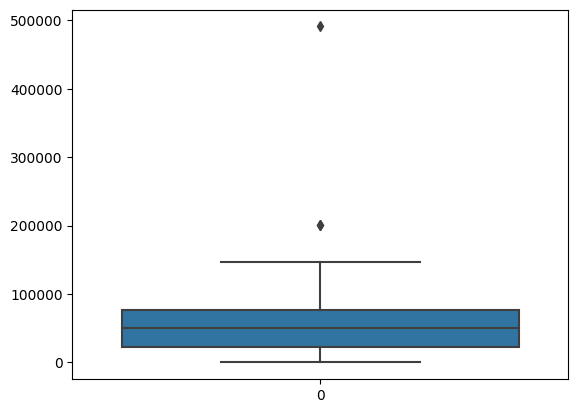

In [ ]:
import seaborn as sns

sns.boxplot(Xs['train']['cityCode'])

In [ ]:
Xs['train'].loc[Xs['train']['cityCode'] > 150000, :]

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,MetersPerRoom,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
299,40200,44,1,1,19,201035,5,4,2006,0,0,2538,7437,985,0,0,913.636364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1326,13591,6,0,1,20,491100,5,9,2000,0,1,8747,5840,675,0,8,2265.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20735,42211,85,1,1,34,200801,8,7,2008,0,0,8434,9238,798,1,9,496.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

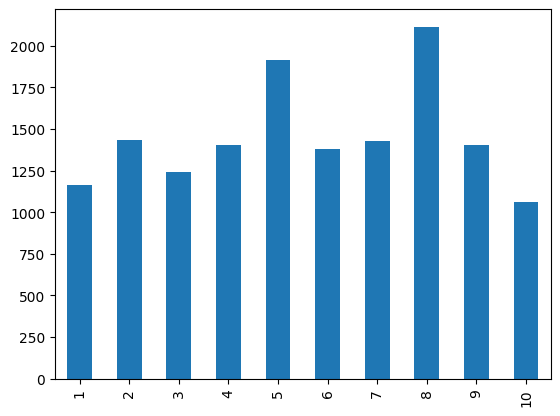

In [ ]:
Xs['train'].cityPartRange.value_counts().sort_index().plot(kind='bar')

In [ ]:
Xs['train']['cityCode'].unique().shape

(6486,)

# Preprocessing

## Define preprocessor

In [ ]:
Xs['train'].columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'MetersPerRoom', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
      dtype='object')

In [ ]:
from sklearn.compose import ColumnTransformer
# No imputers needed, no NAN columns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


num_columns = Xs['train'].columns.tolist()
bool_columns = \
    ['hasYard', 'hasPool', 'isNewBuilt', 'hasStormProtector', 'hasGuestRoom'] + \
    [str(c) for c in np.arange(0, 32).tolist()]

for b in bool_columns:
    # print(b)
    num_columns.remove(b)
    assert not b in num_columns, print(num_columns)

for x in Xs.values():
    assert (set(x.columns.tolist()) - set(num_columns) - set(bool_columns) == set())
    assert 'MetersPerRoom' in x.columns.tolist()

In [ ]:
num_pipeline = make_pipeline(
    # imputer is not needed, no NANs
    StandardScaler()
)

# bool_pipeline = make_pipeline(

# )

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_columns),
    ],
    remainder='passthrough'
)

# Process the data

In [ ]:
Xs['train'].shape, Y_train.shape, Xs['val'].shape, Y_val.shape, Xs['test'].shape, Y_test.shape

((14547, 49), (14547,), (3637, 49), (3637,), (4546, 49), (4546,))

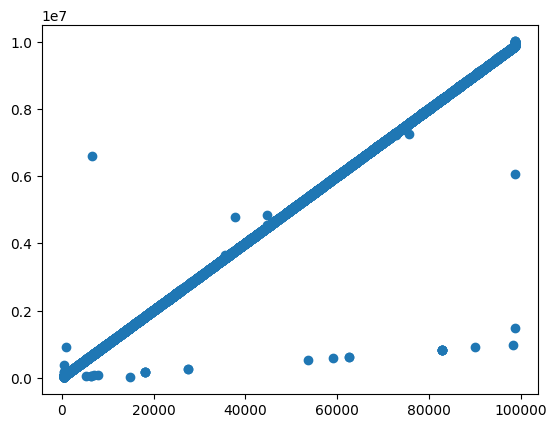

In [ ]:
plt.scatter(Xs['train']['squareMeters'], Y_train)

In [ ]:
X_train_processed = preprocessor.fit_transform(Xs['train'])
X_val_processed = preprocessor.transform(Xs['val'])
X_test_processed = preprocessor.transform(Xs['test'])
X_submission_processed = preprocessor.transform(Xs['submission'])

In [ ]:
X_train_processed.shape

(14547, 49)

# Create the baseline model

## Random forest

### Build the model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train_processed.shape, Ys['train'].shape

((14547, 49), (14547,))

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    verbose=3,
    n_jobs=-1,
)
rf_model.fit(Xs['train'], Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.9s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished


RandomForestRegressor(n_jobs=-1, verbose=3)

In [ ]:
from sklearn.metrics import mean_squared_error

report_results(rf_model, X_train_processed, Y_train)
report_results(rf_model, X_val_processed, Y_val)
# print(mean_squared_error(rf_model.predict(X_val_processed), Y_val, squared=False))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s


76016.89009412499


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


# Linear regression

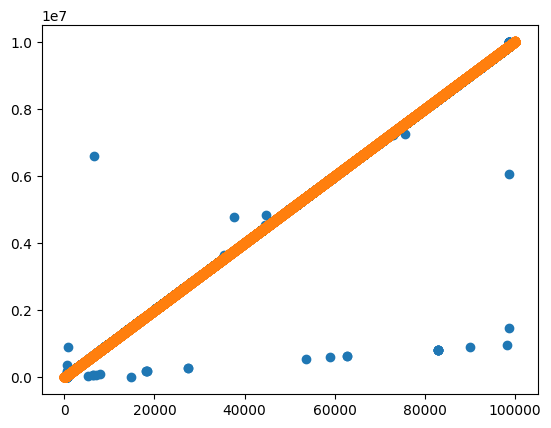

In [ ]:
_, ax = plt.subplots()
ax.scatter(X_train['squareMeters'], Y_train)
ax.scatter(np.arange(100000), [100.14 * i for i in np.arange(100000)])
X_train['p'] = Y_train
X_train['p'] = X_train['p'] / X_train['squareMeters']

In [ ]:
X_train['p'].mean()

100.14343248335804

In [ ]:
Xs['train'].drop(['p'], axis='columns', inplace=True)

In [ ]:
from sklearn.linear_model import LinearRegression


estimator = LinearRegression()
estimator.fit(Xs['train'], Y_train)

LinearRegression()

In [ ]:
report_results(estimator, Xs['train'], Y_train)

225564.55796864338


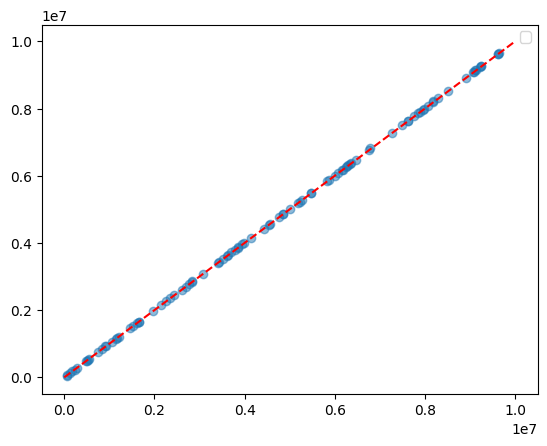

In [ ]:
preds = estimator.predict(Xs['train'])
plt.scatter(x=preds[::150], y=Y_train[::150], alpha=0.5)
plt.plot(np.linspace(0, 10000000, 50), np.linspace(0, 10000000, 50), linestyle='--', color='red')
plt.legend()

<Axes: >

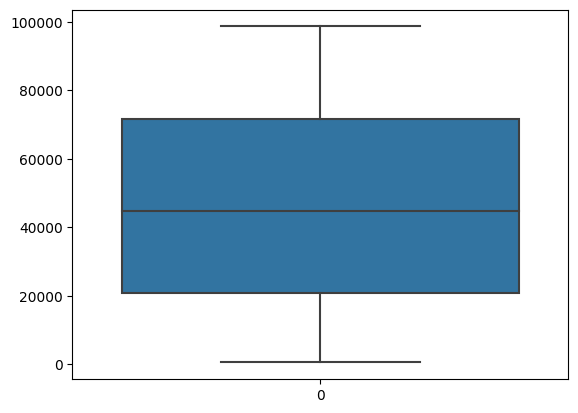

In [ ]:
sns.boxplot(Xs['train']['squareMeters'].values)

<Axes: >

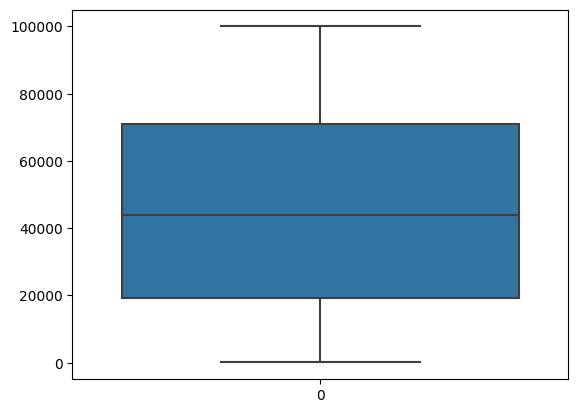

In [ ]:
sns.boxplot(df_submission['squareMeters'].values)

In [ ]:
preds = estimator.predict(df_submission.values)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Randomized search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf_randomized = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions={
        'n_estimators': np.arange(100, 600),
        'max_depth': [None] + np.arange(1, 17).tolist(),
        'verbose': [1],
        'random_state': [RANDOM_STATE]
    },
    scoring='neg_mean_squared_error',
    n_iter=10,
    verbose=5,
    cv=3
)

In [ ]:
rf_randomized_res = rf_randomized.fit(
    X_train_processed,
    Y_train
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=5, n_estimators=113, random_state=42, verbose=1;, score=-48566789696.977 total time=   3.4s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=5, n_estimators=113, random_state=42, verbose=1;, score=-45788066630.915 total time=   2.8s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=5, n_estimators=113, random_state=42, verbose=1;, score=-38810484211.709 total time=   2.8s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   13.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=6, n_estimators=452, random_state=42, verbose=1;, score=-39379787892.239 total time=  13.6s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   13.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=6, n_estimators=452, random_state=42, verbose=1;, score=-30090698595.361 total time=  13.5s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   13.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=6, n_estimators=452, random_state=42, verbose=1;, score=-42178001850.441 total time=  13.9s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


[CV 1/3] END max_depth=13, n_estimators=337, random_state=42, verbose=1;, score=-39505094697.745 total time=  20.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   11.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


[CV 2/3] END max_depth=13, n_estimators=337, random_state=42, verbose=1;, score=-27998098834.590 total time=  18.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   10.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


[CV 3/3] END max_depth=13, n_estimators=337, random_state=42, verbose=1;, score=-43377105648.608 total time=  21.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KeyboardInterrupt: ignored

## FFNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
ffnn = Sequential(
    [
        Dense(300, 'relu'),
        Dense(300, 'relu'),
        Dense(300, 'relu'),
        Dropout(0.2),
        Dense(1, 'linear'),
    ]
)

In [ ]:
ffnn.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

In [ ]:
history = ffnn.fit(
    X_train_processed / X_train_processed.max(),
    Y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
455/455 [==============================] - 6s 6ms/step - loss: 24083876020224.0000
Epoch 2/10
455/455 [==============================] - 3s 6ms/step - loss: 8432740990976.0000
Epoch 3/10
455/455 [==============================] - 2s 5ms/step - loss: 8309659140096.0000
Epoch 4/10
455/455 [==============================] - 2s 5ms/step - loss: 8234813358080.0000
Epoch 5/10
455/455 [==============================] - 2s 5ms/step - loss: 8139946065920.0000
Epoch 6/10
455/455 [==============================] - 2s 4ms/step - loss: 8052283539456.0000
Epoch 7/10
455/455 [==============================] - 2s 5ms/step - loss: 7996538093568.0000
Epoch 8/10
455/455 [==============================] - 3s 6ms/step - loss: 7918112997376.0000
Epoch 9/10
455/455 [==============================] - 2s 5ms/step - loss: 7818139140096.0000
Epoch 10/10
232/455 [==============>...............] - ETA: 1s - loss: 7840496877568.0000

KeyboardInterrupt: ignored

# Experiment record

Metrics: RMSE

0. No preprocessing + RFR 500 estimators:
  - 82654.60836201091 RMSE train
  - 200983.67412852 RMSE val

1. Standard scaling + RF 500 estimators:
    - 82417.68993935444 Train
    - 202054.42155761307 Val

2. After adding "Meters per room" feature + 500 estimators:
- 84125.32984990938 Train
- 193701.18992414087 Val

3. After adding the feature cross + standard scaling + random forest estimator 500:
- 71919.41690217136 Train
- 147986.83360580966 Val

- [DONE] Yard / Pool / NewBuilt / StormProtector / StorageRoom - > do feature cross for 32 new features
- [DONE] Add a 'square meters per room' feature
- Map CityCode feature into a category (city center, bad neighbordhood, etc.)
- Binning ('cityPartRange')